In [1]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.datasets import make_classification
import torch
import numpy as np

# local dependencies 
from contrastive import Contrastive_loss
from utils import plot_tsne,Net_embed



In [2]:

# create random dataset 
X,y = make_classification(n_samples=3000,n_features=16,n_classes=4,n_clusters_per_class=1)



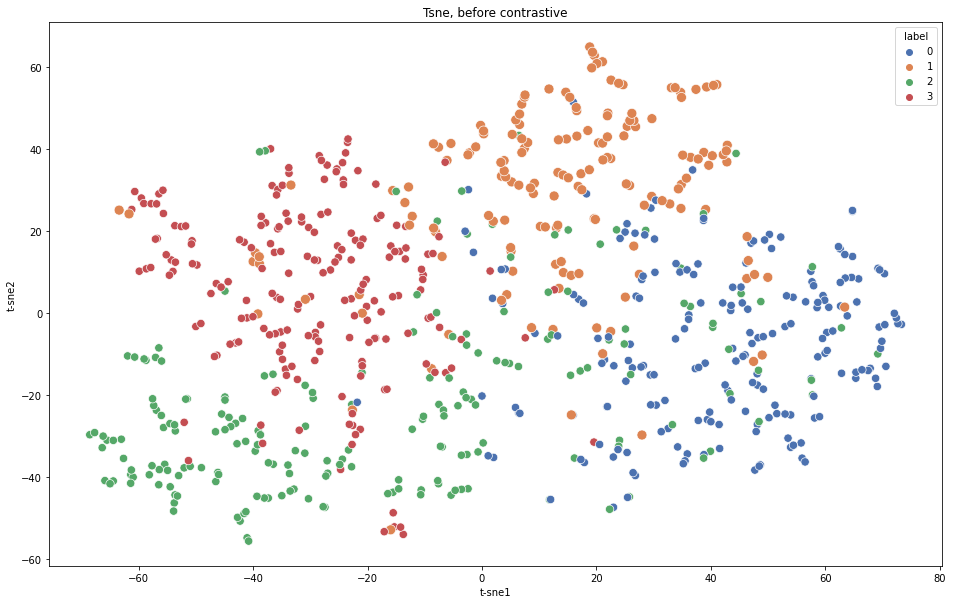

In [4]:
# split data for train-test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=2)
X_train,y_train = torch.from_numpy(X_train).float(),torch.from_numpy(y_train).float()
# Calculate and plot data 2D Tsne  for visualisetion
plot_tsne(X_test,y_test,title='Tsne, before contrastive')




In [5]:
# predict using knn (this may replaces by any other classifier)
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

pred = neigh.predict(X_test)
Acc = (pred == y_test).sum()/len(pred)
print(Acc)

0.848


In [7]:
# train using deep contrastive learnig  
net = Net_embed(input_dim=X_train.shape[1],hidden_dim=128,out_dim=64,drop_prob=0.2)

N_epoch = 20
batches_per_epoch = 750
N_samp_batch = 36
N_data = X_train.shape[0]
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

net.train()

criterion = Contrastive_loss(margin=0.2)
for n in range(N_epoch):
    batch_loss = 0
    for i in range(batches_per_epoch) :
        optimizer.zero_grad()

        # select random batch
        data_samp = np.random.choice(N_data,N_samp_batch,replace=False)
        data_b = X_train[data_samp,:]
        labels_b = y_train[data_samp]
        pred = net(data_b)
        loss = criterion(pred,labels_b)
        loss.backward()
        optimizer.step()
        batch_loss += float(loss)
    
    print(" epoch: {}  Loss:  {:.3f}".format(n,batch_loss))

 epoch: 0  Loss:  60.632
 epoch: 1  Loss:  50.164
 epoch: 2  Loss:  47.954
 epoch: 3  Loss:  45.151
 epoch: 4  Loss:  44.886
 epoch: 5  Loss:  43.521
 epoch: 6  Loss:  42.786
 epoch: 7  Loss:  41.613
 epoch: 8  Loss:  40.041
 epoch: 9  Loss:  39.245
 epoch: 10  Loss:  39.632
 epoch: 11  Loss:  37.203
 epoch: 12  Loss:  37.460
 epoch: 13  Loss:  37.200
 epoch: 14  Loss:  35.739
 epoch: 15  Loss:  36.311
 epoch: 16  Loss:  36.326
 epoch: 17  Loss:  34.800
 epoch: 18  Loss:  36.191
 epoch: 19  Loss:  36.313


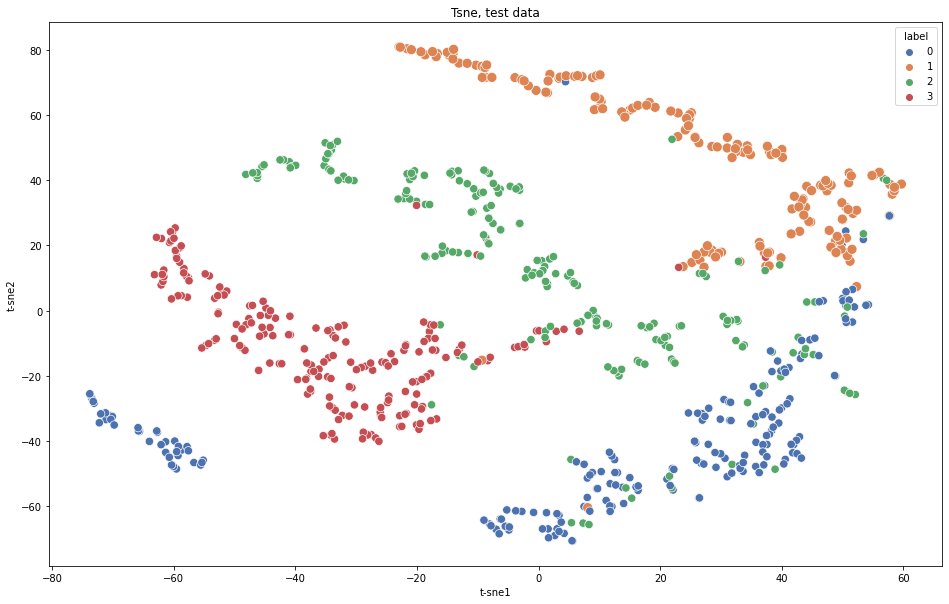

In [8]:
# calculate test data embedding and Tsne
net.eval()
pred_test = net(torch.from_numpy(X_test).float())

plot_tsne(pred_test.detach().numpy(),y_test,title = 'Tsne, test data')

In [11]:
# calculate Knn for test dataset after contrastive

pred_train = net(X_train)

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(pred_train.detach().numpy(), y_train.numpy())

pred = neigh.predict(pred_test.detach().numpy())
Acc = (pred == y_test).sum()/len(pred)
print(Acc)

0.924
